### [1. Подготовка](#preparation)
* [1.1. Импорт библиотек](#libs)
* [1.2. Вспомогательные функции](#func)
* [1.3. Загрузка тренировочных данных](#load_train)
* [1.4 Загрузка тестовых данных](#load_test)

### [2. EDA](#EDA)
* [2.1. Анализ целевой переменной](#target)
    * [2.1.1 Выводы о целефой переменной](#target_conclusion)
* [2.2. Анализ признаков](#feature_analysis)
    * [2.2.1 Дискретные признаки](#num_features)
        * [2.2.1.1. Rooms](#num_features_Rooms)
        * [2.2.1.2. Square](#num_features_Square)
        * [2.2.1.3. LifeSquare](#num_features_LifeSquare)
        * [2.2.1.4. KitchenSquare](#num_features_KitchenSquare)
        * [2.2.1.5. Floor](#num_features_Floor)
        * [2.2.1.6. HouseFloor](#num_features_Floor)
    * [2.2.2 Категориальные признаки](#cat_features)
        * [2.2.2.1. HouseYear](#cat_features_HouseYear)
    * [2.2.3 Проверка валидности данных](#check_valid)
        * [2.2.3.1 LifeSquare, Square, KitchenSquare](#check_valid_Square)
        * [2.2.3.2 Floor, HouseFloor](#check_valid_Floor)
    * [2.2.4 Оценка линейной корреляции признаков](#check_corr)
    * [2.2.5 Первичные выводы выводы](#firs_conclusion)
    
### [3. Обработка признаков](#feature_processing)
* [3.1. Обработка выбросов](#emission_treatment)
* [3.2. Построение новых признаков](#feature_generating)    

### [4. Построение модели](#modeling)
* [4.1. Разбиение на train и test](#train_test) 
* [4.2 Отбор признаков](#feature_selection)
* [4.3. Обучение модели](#learning)
    * [4.3.1 Основная модель](#main_model)
    * [4.3.2 Обучение модели](#alter_models)
* [4.4. Оценка модели](#evaluation)
* [4.5. Кросс-валидация](#cross_validation)
    * [4.5.1 Основная модель](#main_CV)
    * [4.5.2 Альтернативные модели](#alter_CV)
* [4.6. Важность признаков](#feature_importance)
* [4.7. Прогнозирование на тестовом датасете](#forecasting)

# 1. Подготовка <a class='anchor' id='preparation'>

## 1.1. Импорт библиотек <a class='anchor' id='libs'>

In [1]:
import numpy as np
import pandas as pd
import random as rnd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from scipy import stats

from datetime import date

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

TRAIN_DATASET_PATH = '../input/inputrealestate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '../input/inputrealestate-price-prediction-moscow/test.csv'
SAMPLE_SUBMISSION_PATH  = '../input/inputrealestate-price-prediction-moscow/sample_submission.csv'

## 1.2. Вспомогательные функции <a class='anchor' id='func'>

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
#     print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
#     print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)) + "\n" +
          "Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(test_true_values, test_pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(test_true_values, test_pred_values), 3))
         )
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
# Функция получения данных внутри или вне интервала
def feature_filter(df, feature, min_val, max_val, trusted = True, with_sort = False):

    trusted_msk = (df[feature] >= min_val) & (train_df[feature] <= max_val)
    untusted_msk = (df[feature] < min_val) | (train_df[feature] > max_val)
    
    filtered_df = df[trusted_msk if trusted else ~trusted_msk]
        
    if with_sort:
        return filtered_df.sort_values(feature)
    else:
        return filtered_df

In [5]:
def print_untrusted(scales, title):
    #     
    x_scale = scales.index
    y_scale = scales.values
    if not x_scale.empty:
        x_ext = np.std(x_scale)
        y_ext = np.std(y_scale)

        #     
        x_min, x_max = scales.index.min() - x_ext, scales.index.max() + x_ext
        y_min, y_max = scales.values.min() - y_ext, scales.values.max() + y_ext

        #     
        plt.scatter(x_scale, y_scale)

        #     
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.title(title)
        plt.xlabel('Значение')
        plt.ylabel('Частота')
        plt.show()

In [6]:
def print_trust_untrust(df, feature, min_val, max_val, bin_count=30):
    #     
    trusted_df = feature_filter(df, feature, min_val, max_val, True)
    untrusted_df = feature_filter(df, feature, min_val, max_val, False)
    x_ext = trusted_df[feature].std() * 0.1
    
    # 
    x_min_trust, x_max_trust = min_val - x_ext, max_val + x_ext
    plt.hist(trusted_df[feature], bins=bin_count)
    plt.xlim(x_min_trust, x_max_trust)
    plt.title('Доверительный интервал')
    plt.xlabel('Значение')
    plt.ylabel('Частота')
    plt.show()
    
    vc = untrusted_df[feature].value_counts()
    if vc[vc.index < min_val] is not None:
        print_untrusted(vc[vc.index < min_val], 'Аномальные значения слева')
    if vc[vc.index > min_val] is not None:
        print_untrusted(vc[vc.index > min_val], 'Аномальные значения справа')

## 1.3. Загрузка тренировочных данных <a class='anchor' id='load_train'>

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df['HouseFloor'] = train_df['HouseFloor'].astype(int)
train_df = reduce_mem_usage(train_df)
train_df.tail()

Memory usage of dataframe is 1.49 MB
Memory usage after optimization is: 0.46 MB
Decreased by 69.2%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250
9999,7202,94,1.0,35.815475,22.301367,6.0,9,9,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.625000


In [8]:
train_df[train_df['HouseFloor'] < 0].value_counts().index.empty

True

## 1.4. Загрузка тестовых данных <a class='anchor' id='load_test'>

In [9]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df = reduce_mem_usage(test_df)
test_df.tail()

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698120,94.521461,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003260,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [10]:
# Смотрим количество строк в датасетах
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [11]:
# переводим признаки в категории и общий список типов
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
# train_df['HouseYear'] = train_df['HouseYear'].astype(str)

train_df.dtypes

Id                 object
DistrictId         object
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor           int8
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

# 2. EDA <a class='anchor' id='EDA'>

* [2.1. Анализ целевой переменной](#target)
    * [2.1.1 Выводы о целефой переменной](#target_conclusion)
* [2.2. Анализ признаков](#feature_analysis)
    * [2.2.1 Дискретные признаки](#num_features)
        * [2.2.1.1. Rooms](#num_features_Rooms)
        * [2.2.1.2. Square](#num_features_Square)
        * [2.2.1.3. LifeSquare](#num_features_LifeSquare)
        * [2.2.1.4. KitchenSquare](#num_features_KitchenSquare)
        * [2.2.1.5. Floor](#num_features_Floor)
        * [2.2.1.6. HouseFloor](#num_features_Floor)
    * [2.2.2 Категориальные признаки](#cat_features)
        * [2.2.2.1. HouseYear](#cat_features_HouseYear)
    * [2.2.3 Проверка валидности данных](#check_valid)
        * [2.2.3.1 LifeSquare, Square, KitchenSquare](#check_valid_Square)
        * [2.2.3.2 Floor, HouseFloor](#check_valid_Floor)
    * [2.2.4 Оценка линейной корреляции признаков](#check_corr)
    * [2.2.5 Первичные выводы выводы](#firs_conclusion)

## 2.1. Анализ целевой переменной <a class='anchor' id='target'>

In [12]:
# инициализируем целевую переменную
target_name = 'Price'
target =  train_df[target_name]

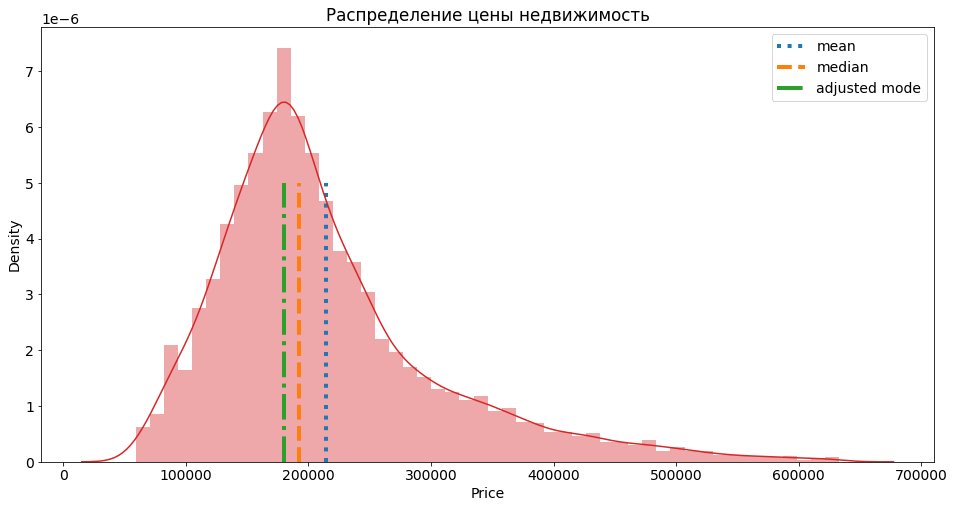

In [13]:
plt.figure(figsize = (16, 8))

target_mean = round(target.mean(), 2)
target_median = target.median()

target_bins = target // 10000 * 10000
target_adjusted_mode = target_bins.mode()[0]

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_adjusted_mode] * 10, y, label='adjusted mode', linestyle='-.', linewidth=4)

plt.title('Распределение цены недвижимость')


sns.distplot(target, bins=50) 

plt.legend()
# saveplot('ex_3_6.png')
plt.show()

In [14]:
# оценим крвизну ассиметрии целевой переменной
target.skew()

1.3668774

In [15]:
# получим логариф от целевой переменной
target_log = target.apply(np.log)

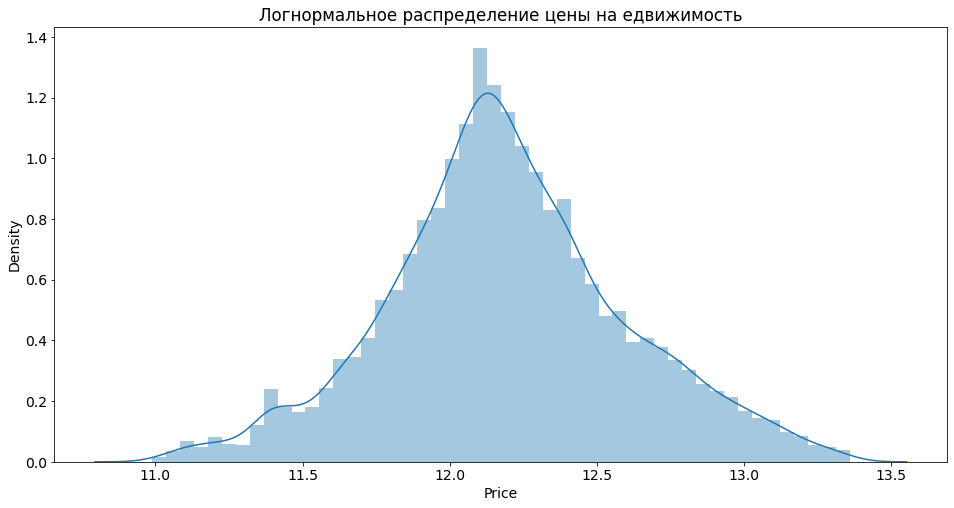

In [16]:
# и построим график логнормального распределения
plt.figure(figsize = (16, 8))

plt.title('Логнормальное распределение цены на едвижимость')
sns.distplot(target_log, bins=50) 

# saveplot('ex_3_6.png')
plt.show()

In [17]:
# оценим кривизну ассиметрии после логарифмирования
target_log.skew()

0.10779469

### 2.1.1 Выводы о целефой переменной <a class='anchor' id='target_conclusion'>

1. На основании графика распределния целевой переменной и кривизны ассиметрии, делаем предположении, что целевая переменная сильно отклоняется от нормального распределения в право, что может говорить о завышении цен на недвижимость.
1. В тоже время логнормальное распределение показывает незначительное отклонение в право, что может свидетельствовать о нормальности целевой переменной.
1. Явных аномалий в целевой переменной не обнаружено

## 2.2. Анализ признаков <a class='anchor' id='feature_analysis'>

In [18]:
# проверяем в каких фичах есть пропуски
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  object  
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  int8    
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [19]:
# разделяем признаки на числовые и категориальные
num_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
                'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1']
# год постройки отнесем к категшориальным признакам так как нет прямой зависимости между годом постройки и ценой
cat_features = ['HouseYear', 'Ecology_2', 'Ecology_3', 'Helthcare_2', 'Shops_1', 'Shops_2']

# смотрим статистику по столбцам
train_df.describe() 

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


### 2.2.1 Дискретные признаки <a class='anchor' id='num_features'>

In [20]:
# Оценим признаки по отклонению медианы от среднего
# выбираем числовые признаки
df_num_features = train_df[num_features]

# доля медианого значени првышение которой считается выбросным
crit_rec = 0.05

# находим отклоняющиеся показатели
unvalid_feaeres = (df_num_features.mean() - df_num_features.median()).abs() > df_num_features.median() * crit_rec
unvalid_feaeres[unvalid_feaeres.values]

Rooms           True
Square          True
LifeSquare      True
Floor           True
Ecology_1       True
Social_3        True
Healthcare_1    True
dtype: bool

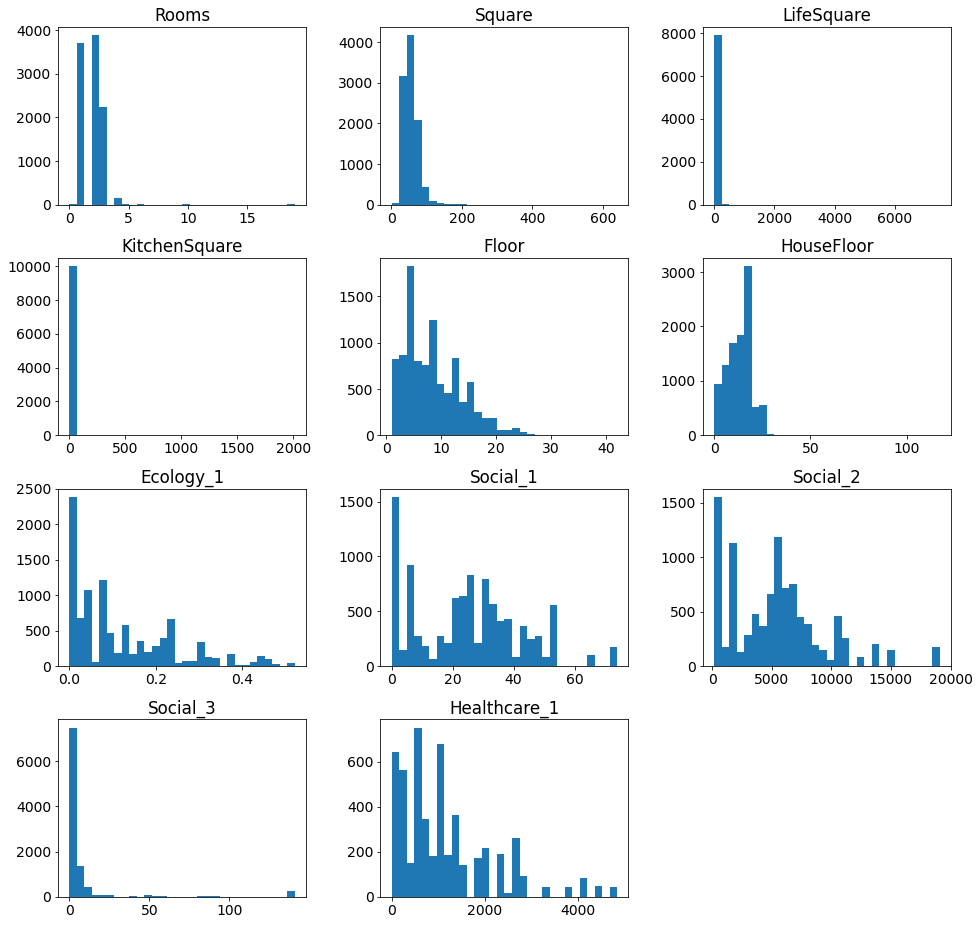

In [21]:
# строим гистограммы по распределению каждой фичи
df_num_features.hist(figsize=(16, 16), bins=30, grid=False);

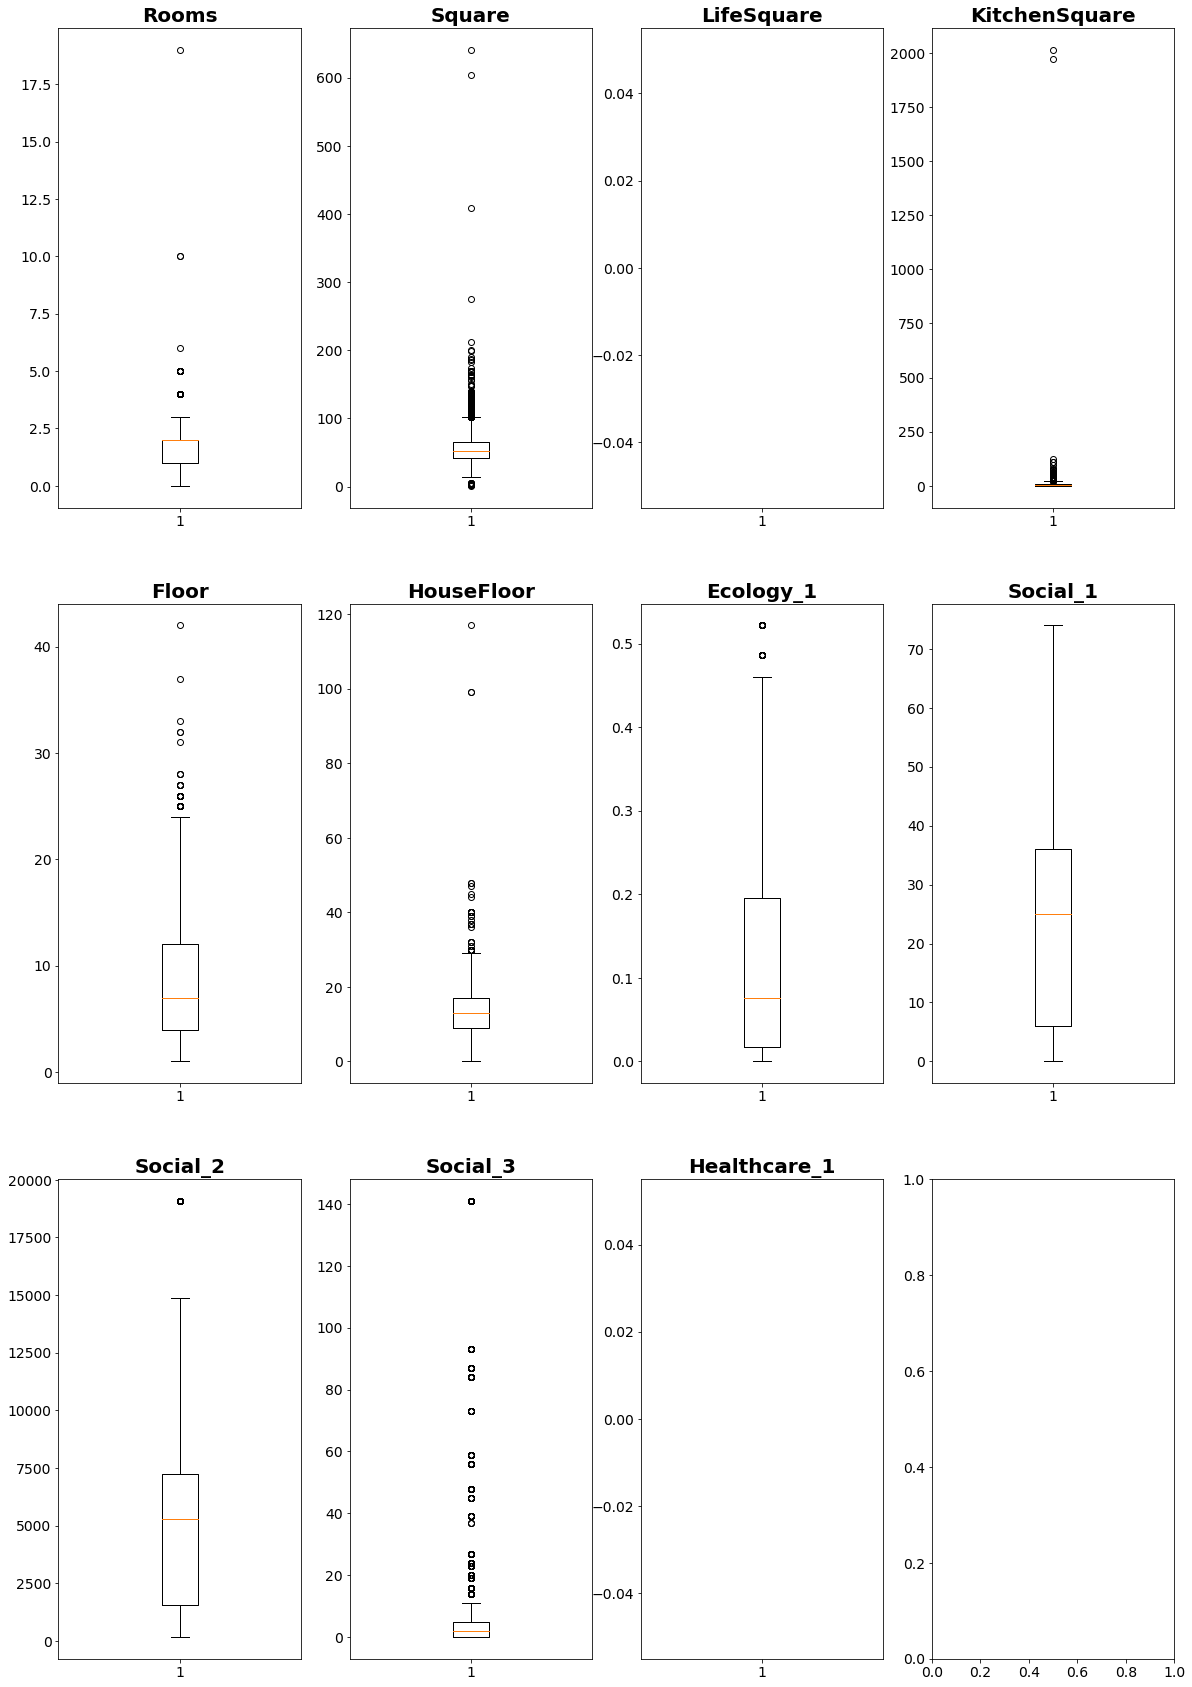

In [22]:
# задаем количество строк  столбцов
col_count = 4
row_count = len(num_features) // col_count + 1

# задаем сетку
fig, ax = plt.subplots(nrows=row_count, ncols=col_count, figsize=(20, 30))
axes = ax.flatten()

# построим для каждого признака ящик с усами
for i, feature in enumerate(num_features, 0):
    cur_ax = axes[i]
    cur_ax.boxplot(df_num_features[feature])
    cur_ax.set_title(feature, fontweight="bold", size=20) # Title
   
plt.show()

#### 2.2.1.1. Rooms <a class='anchor' id='num_features_Rooms'>

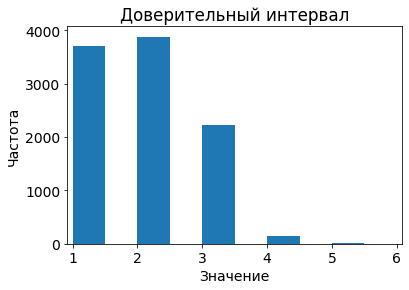

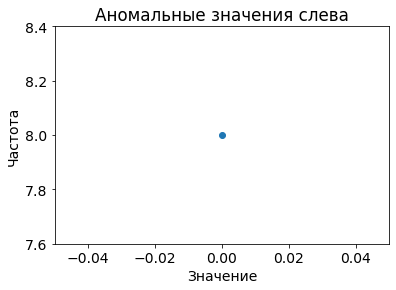

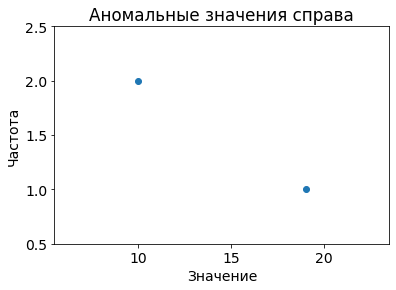

In [23]:
# оцениваем объекты в выбраном интервале и вне его
print_trust_untrust(train_df, 'Rooms', 1, 6, 10)

#### 2.2.1.2. Square <a class='anchor' id='num_features_Square'>

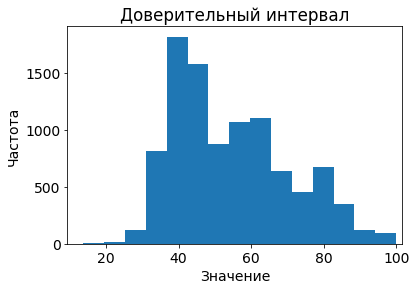

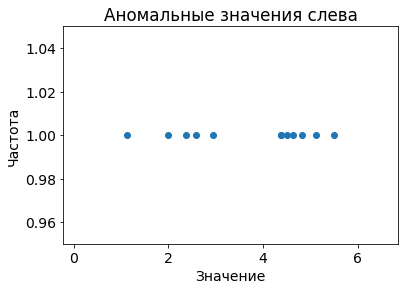

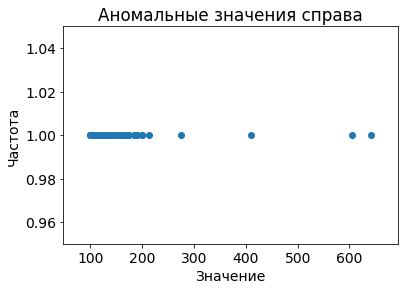

In [24]:
print_trust_untrust(train_df, 'Square', 11, 100, 15)

#### 2.2.1.3. LifeSquare <a class='anchor' id='num_features_LifeSquare'>

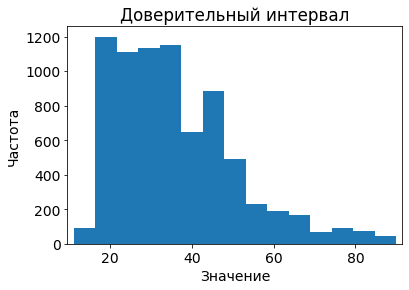

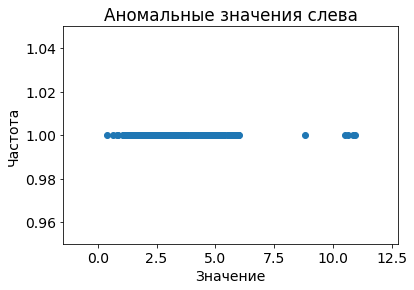

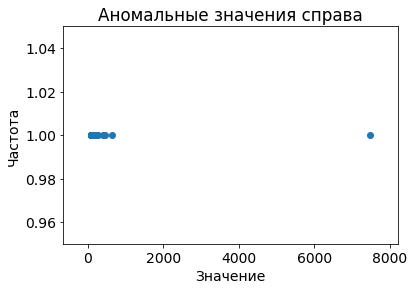

In [25]:
# осекаем все что больше 1000 для наглядности графика
print_trust_untrust(train_df, 'LifeSquare', 11, 90, 15)

#### 2.2.1.4. KitchenSquare <a class='anchor' id='num_features_KitchenSquare'>

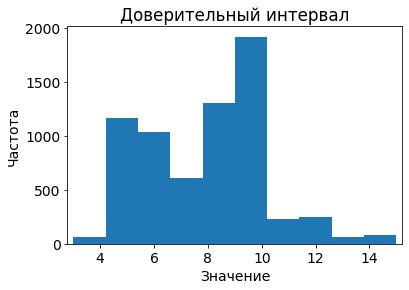

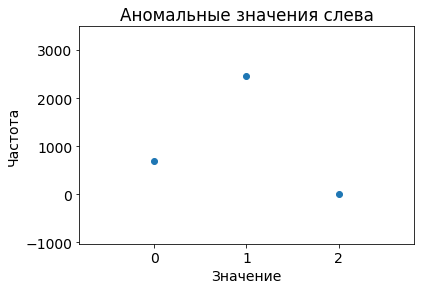

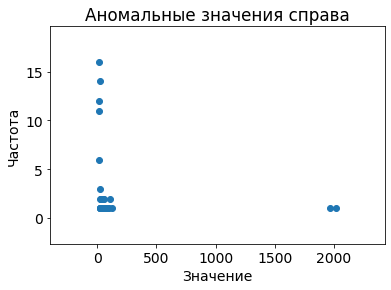

In [26]:
print_trust_untrust(train_df, 'KitchenSquare', 3, 15, 10)

#### 2.2.1.5. Floor <a class='anchor' id='num_features_Floor'>

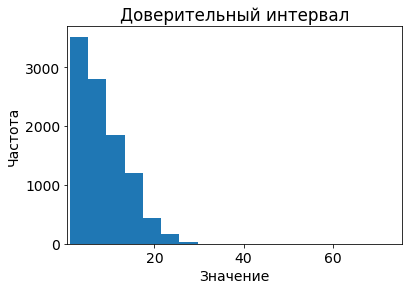

In [27]:
print_trust_untrust(train_df, 'Floor', 1, 75, 10)

#### 2.2.1.6. HouseFloor <a class='anchor' id='num_features_Floor'>

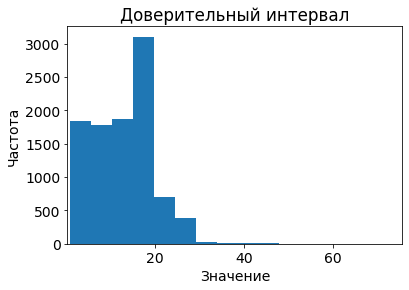

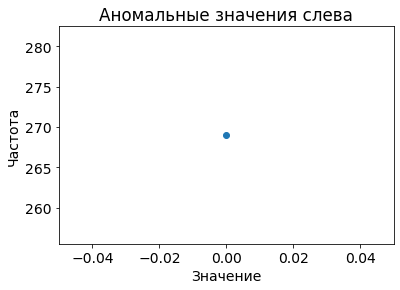

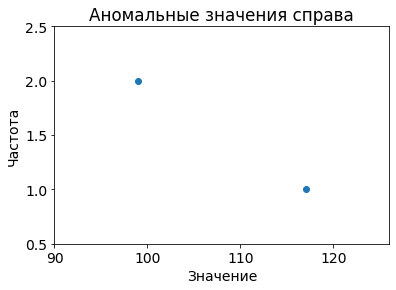

In [28]:
print_trust_untrust(train_df, 'HouseFloor', 1, 75, 10)

### 2.2.2 Категориальные признаки <a class='anchor' id='cat_features'>

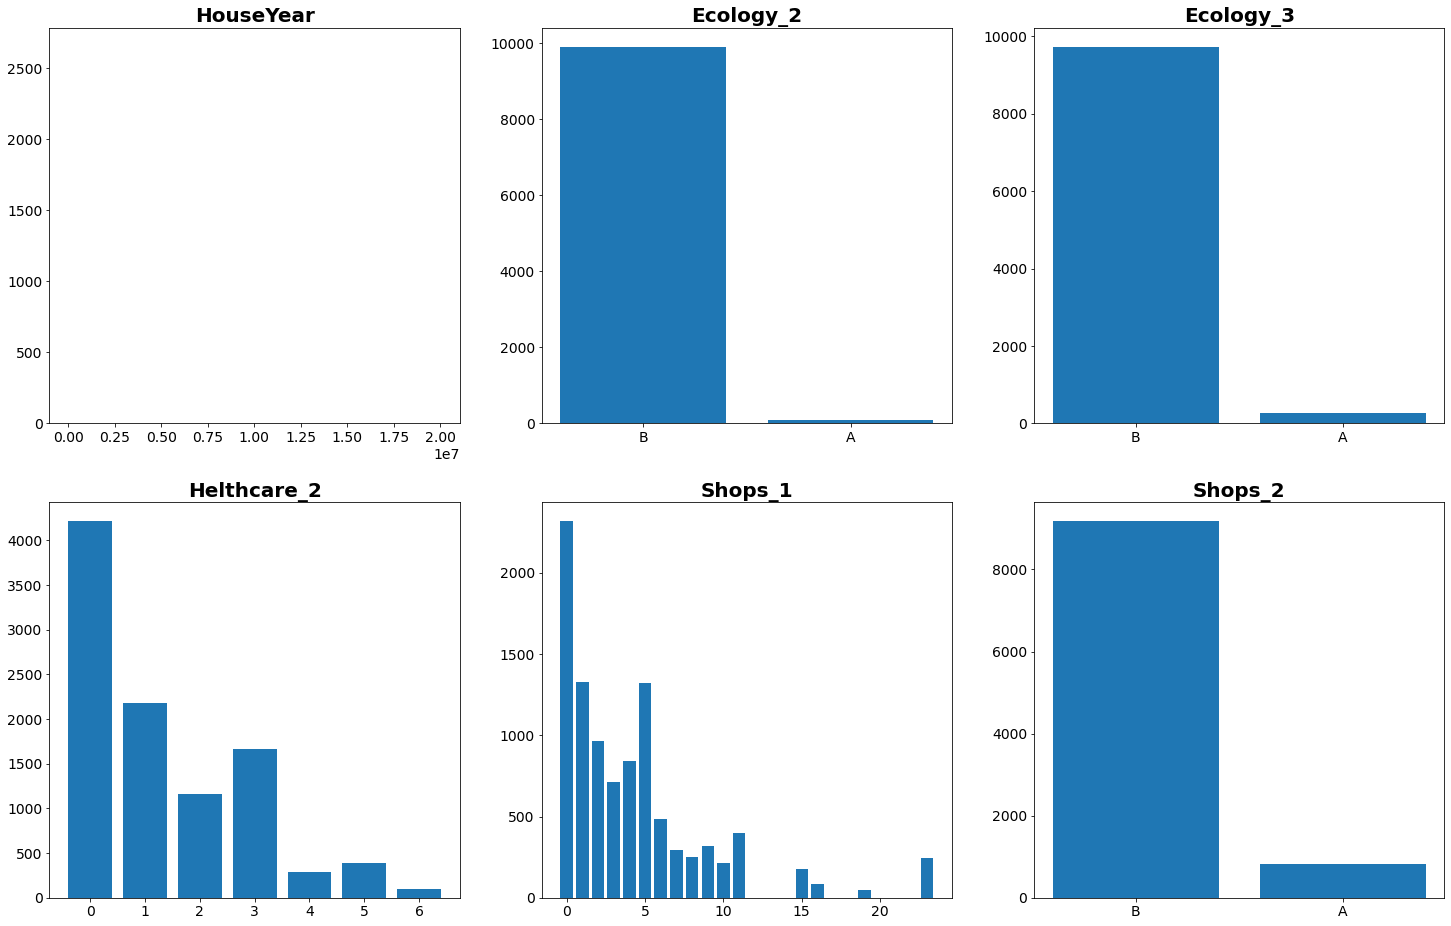

In [29]:
# задаем количество строк  столбцов
col_count = 3
row_count = len(cat_features) // col_count 


# задаем сетку
fig, ax = plt.subplots(nrows=row_count, ncols=col_count, figsize=(25, 16))
axes = ax.flatten()

# построим для каждого признака ящик с усами
for i, feature in enumerate(cat_features, 0):
    cur_ax = axes[i]
    counts = train_df[feature].value_counts()
    cur_ax.bar(counts.index, counts.values)
    cur_ax.set_title(feature, fontweight="bold", size=20) # Title
   
plt.show()

#### 2.2.2.1. HouseYear <a class='anchor' id='cat_features_HouseYear'>

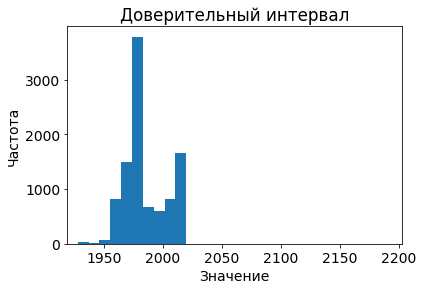

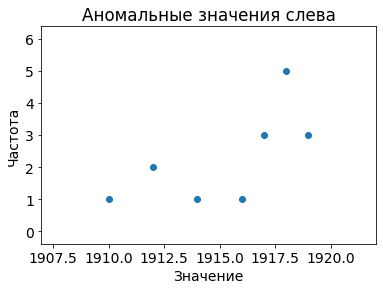

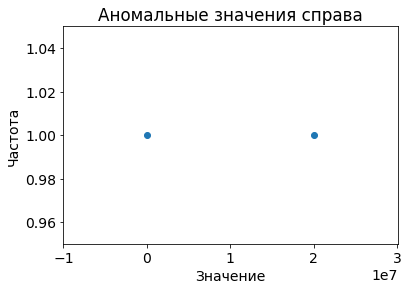

In [30]:
print_trust_untrust(train_df, 'HouseYear', 1921, 2201, 10)

### 2.2.3 Проверка валидности данных <a class='anchor' id='check_valid'>

#### 2.2.3.1 LifeSquare, Square, KitchenSquare <a class='anchor' id='check_valid_Square'>

In [31]:
extrs = {'Square': (11, 100), 'LifeSquare': (11, 90), 'KitchenSquare': (3, 15)}

# создаем ДФ в котором будем хранить площади без экстремальных значений
trusted_squares_df = train_df['Id'].to_frame().set_index('Id')
for sq in extrs.keys():
    t_sq = feature_filter(train_df, sq, extrs[sq][0], extrs[sq][1])
    trusted_squares_df = trusted_squares_df.join(t_sq[['Id', sq]].set_index('Id'))

# плащадь комнат и кухни вместе
life_kitchen_sq = trusted_squares_df['LifeSquare'] + trusted_squares_df['KitchenSquare']

# создаем различные булевые маски для проверки аномалий
large_life_msk = trusted_squares_df['Square'] <= trusted_squares_df['LifeSquare']
large_kitchen_msk = trusted_squares_df['Square'] <= trusted_squares_df['KitchenSquare']
large_kitchen_life_msk = trusted_squares_df['Square'] <= life_kitchen_sq

# маска нормальных данных
norm_msk = trusted_squares_df['Square'] > life_kitchen_sq

norm = trusted_squares_df[norm_msk]

# получаем площадь нежилых помещений в невыбросных данных
norm['non_res_sq'] = norm['Square'] - norm['KitchenSquare'] - norm['LifeSquare']

# оцениваем процент площади нежилых помещений относительно жилой площади
non_res_perc = round(np.mean(norm['non_res_sq'] / norm['LifeSquare']), 4)

# рассчитываем площадь квартиры включая нежилые помещения
with_non_res_sq = life_kitchen_sq + trusted_squares_df['LifeSquare'] * non_res_perc
with_non_res_msk = trusted_squares_df['Square'] < with_non_res_sq

# # при сравнении исключаем возможные пересечения
# # площадь комнат больше или равна площади всей квартиры
large_life_cnt = len(trusted_squares_df[large_life_msk & 
                                        ~large_kitchen_msk & 
                                        ~large_kitchen_life_msk].index)

# площадь кухни больше или равна плозади всей квартира 
large_kitchen_cnt = len(trusted_squares_df[large_kitchen_msk & 
                                           ~large_life_msk & 
                                           ~large_kitchen_life_msk].index)

# площадь кухни и комнат больше или равна плозади всей квартира 
large_kitchen_life_cnt = len(trusted_squares_df[large_kitchen_life_msk & 
                                                ~large_life_msk & 
                                                ~large_kitchen_msk].index)

# площадь кухни, комнат и нежилых помещений больше плозади всей квартира 
with_non_res_cnt = len(trusted_squares_df[with_non_res_msk & 
                                          ~large_kitchen_life_cnt].index)

print(f'Кол-во объектов где комнаты большей всей квартиры - {large_life_cnt}')
print(f'Кол-во объектов где кухня большей всей квартиры - {large_kitchen_cnt}')
print(f'Кол-во объектов где где кухня и комнаты большей всей квартиры - {large_kitchen_life_cnt}')
print(f'Кол-во объектов без нежилых помещений - {with_non_res_cnt}')
print(f'Процент площади нежилых помещений относительно жилой площади - {non_res_perc:.2%}')

Кол-во объектов где комнаты большей всей квартиры - 320
Кол-во объектов где кухня большей всей квартиры - 0
Кол-во объектов где где кухня и комнаты большей всей квартиры - 205
Кол-во объектов без нежилых помещений - 0
Процент площади нежилых помещений относительно жилой площади - 42.75%


#### 2.2.3.2 Floor, HouseFloor <a class='anchor' id='check_valid_Floor'>

In [32]:
trusted_floor = feature_filter(train_df, 'Floor', 1, 75)
trusted_Hfloor = feature_filter(train_df, 'HouseFloor', 1, 75)

trusted_floor_df = train_df['Id'].to_frame().set_index('Id')
trusted_floor_df = trusted_floor_df.join([trusted_floor[['Id', 'Floor']].set_index('Id'), 
                                          trusted_Hfloor[['Id', 'HouseFloor']].set_index('Id')
                                         ])

too_hight_msk = trusted_floor_df['HouseFloor'] < trusted_floor_df['Floor']

too_hight_cnt = len(trusted_squares_df[too_hight_msk].index)

print(f'Кол-во объектов где этаж выше этажности дома - {too_hight_cnt}')

Кол-во объектов где этаж выше этажности дома - 1556


### 2.2.4 Оценка линейной корреляции признаков <a class='anchor' id='check_corr'>

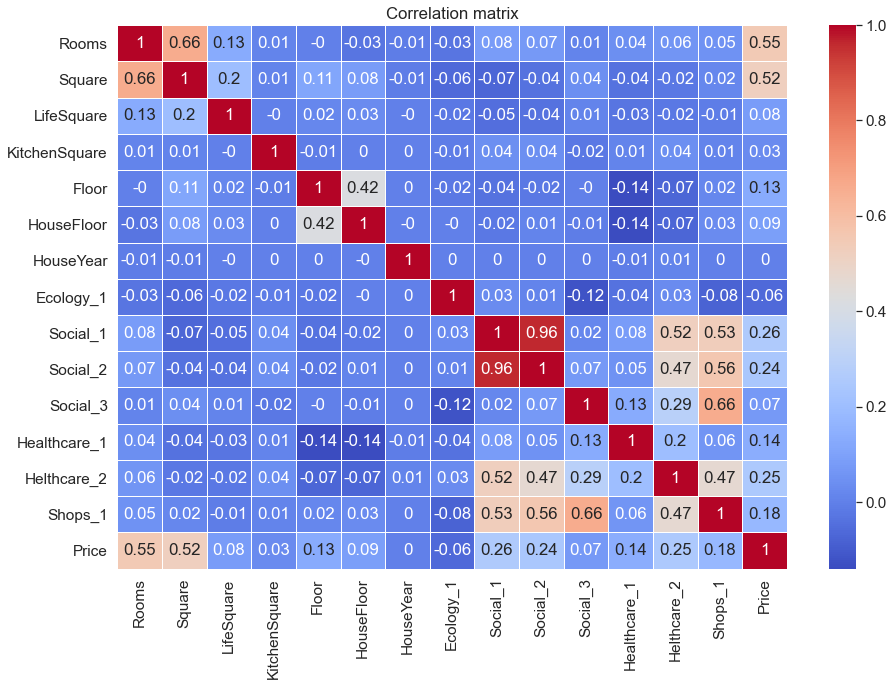

In [33]:
corr_matrix = train_df.corr()

plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### 2.2.5 Первичные выводы выводы <a class='anchor' id='firs_conclusion'>

1. Фичи LifeSquare, Healthcare_1 содержат много пустых значений
1. На основании статистических данных и гистограмм делаем вывыод о наличии отклонений в признаках
    1. Rooms
    1. Square
    1. LifeSquare
    1. Floor
    1. HouseYear
1. Основываясь на данных можно предположить аномальную природу следующих показателей
    1. Ecology_1
    1. Social_3
    1. Healthcare_1
    1. Helthcare_2
    1. Shops_1 
    но ввиду неизвестно происхождения признаков решение о ваоидности данных пока откладываю.
1. На основании матрицы корреляци на неочищенных данных можно сделать заключение о наличи связей между признаками
    1. Rooms и Square
    1. Rooms и Price
    1. Square и Price
    1. Social_1 и Social_2
    1. Social_1 и Shops_1
    1. Social_1 и Helthcare_2
    1. Social_2 и Shops_1
    1. Social_2  и Helthcare_2
    1. Social_3  и Shops_1
    1. Helthcare_2 и Shops_1
1. На основании проверок валидности делаем выводы о наличии не валидных данных в признаках
    1. Rooms - количество комнат не может быть меньше 1 и больше 6
    1. Square - нормальные значения лежат в интервале от 11 до 100
    1. LifeSquare - нормальные значения лежат в интервале от 11 до 90, при этом LifeSquare должен быть меньше Square - KitchenSquare - х. Где х не жилая площадь 
    1. KitchenSquare - нормальные значения лежат в интервале от 1 до 15, при этом KitchenSquare должен быть меньше Square - LifeSquare - х.
    1. Среди объектов с площадьми соотвествующими нормальным значениям было обнаружено
        1. 320 объектов где площадь комнат больше или равна площади всей квартиы
        1. 205 объектов где суммарная площадь кухни и комнат больше или равна площадь всей квартиры
        1. ОБъектов где суммарная площадь кухни и комнат в ключая 1. Фичи LifeSquare, Healthcare_1 содержат много пустых значений
1. На основании статистических данных и гистограмм делаем вывыод о наличии отклонений в признаках
    1. Rooms
    1. Square
    1. LifeSquare
    1. Floor
    1. HouseYear
1. Основываясь на данных можно предположить аномальную природу следующих показателей
    1. Ecology_1
    1. Social_3
    1. Healthcare_1
    1. Helthcare_2
    1. Shops_1 
    но ввиду неизвестно происхождения признаков решение о ваоидности данных пока откладываю.
1. На основании матрицы корреляци на неочищенных данных можно сделать заключение о наличи связей между признаками
    1. Rooms и Square
    1. Rooms и Price
    1. Square и Price
    1. Social_1 и Social_2
    1. Social_1 и Shops_1
    1. Social_1 и Helthcare_2
    1. Social_2 и Shops_1
    1. Social_2  и Helthcare_2
    1. Social_3  и Shops_1
    1. Helthcare_2 и Shops_1
1. На основании проверок валидности делаем выводы о наличии не валидных данных в признаках
    1. Rooms - количество комнат не может быть меньше 1 и больше 6
    1. Square - нормальные значения лежат в интервале от 11 до 100
    1. LifeSquare - нормальные значения лежат в интервале от 11 до 90, при этом LifeSquare должен быть меньше Square - KitchenSquare - х. Где х не жилая площадь 
    1. KitchenSquare - нормальные значения лежат в интервале от 1 до 15, при этом KitchenSquare должен быть меньше Square - LifeSquare - х.
    1. Среди объектов с площадьми соотвествующими нормальным значениям было обнаружено
        1. 320 объектов где площадь комнат больше или равна площади всей квартиы
        1. 205 объектов где суммарная площадь кухни и комнат больше или равна площадь всей квартиры
        1. ОБъектов где суммарная площадь кухни и комнат в ключая нежилые помещения (42.75% от жилой площади) больше площади всей квартиры выялено не было
        1. ОБъектов где площадь кухни больше площади всей квартиры выялено не было
    1. Floor - нормальные значения лежат в интервале от 1 до 75, при этом Floor должен быть меньше или равен HouseFloor
    1. HouseFloor - нормальные значения лежат в интервале от 1 до 75.
    1. Среди объектов с этажностью соотвествующими нормальным значениям было обнаружено
        1. 1556 объектов где этаж квартиры выше этажности дома
    1. HouseYear - нормальные значения расположены в интервале от тегущий год - 100 лет до текущий год
    1. Ecology_1 - скорее всего это некая вероятность, где значене 0 означает осутствие измерения, таким образом нормальные значения расположены в интервале от 0 включительно до 1 не включительно
    1. Social_1 - вероятно некий процент с нормальными значениями в интервале от 0 включительно до 100 включительно
    1. Social_2 - вероятно некий количественный показатель, так что нормальные значения располагаются в интервале от 0 и выше. Имеет сильную линейную зависимость с Social_1
    1. Helthcare_2	- категориальный признак со значением больше или равно 0 (возможно это дни недлели)
    1. Shops_1 - вероятно как то связано с суточным ритмом, допустимы интервал от 0 до 23
    1. Ecology_2, Ecology_3, Shops_2 - категориальные признаки, аномалий не обнаружено. 
        1. ОБъектов где площадь кухни больше площади всей квартиры выялено не было
    1. Floor - нормальные значения лежат в интервале от 1 до 75, при этом Floor должен быть меньше или равен HouseFloor
    1. HouseFloor - нормальные значения лежат в интервале от 1 до 75.
    1. Среди объектов с этажностью соотвествующими нормальным значениям было обнаружено
        1. 1556 объектов где этаж квартиры выше этажности дома
    1. HouseYear - нормальные значения расположены в интервале от тегущий год - 100 лет до текущий год
    1. Ecology_2, Ecology_3, Shops_2 - категориальные признаки, аномалий не обнаружено.

# 3 Обработка признаков <a class='anchor' id='feature_processing'>

* [3.1. Обработка выбросов](#emission_treatment)
* [3.2. Построение новых признаков](#feature_generating)    

## 3.1 Обработка выбросов <a class='anchor' id='emission_treatment'>

In [34]:
class DataPreprocessing:
    """Подготовка исходных данных"""
    extrs = {'Rooms': (1, 8),
             'Square': (11, 100),
             'LifeSquare': (11, 90),
             'KitchenSquare': (3, 15),
             'Floor': (1, 75),
             'HouseFloor': (1, 75),
             'HouseYear': (date.today().year - 100, date.today().year)
            }
    non_res_perc = 0.4275

    def __init__(self):
        """Параметры класса"""
        
        self.trusted_sqs = None
        self.mean_room_sq = None
        self.t_square_median = None
        self.kitchen_perc = None
        self.life_perc = None
        self.medians = None
        
    def get_trusted_squares(self, df):
        """Получение надежных площадей"""
        t_squares = df['Id'].to_frame().set_index('Id')
        squares = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare']
        for sq in squares:
            t_sq = feature_filter(df, sq, self.extrs[sq][0], self.extrs[sq][1])
            t_squares = t_squares.join(t_sq[['Id', sq]].set_index('Id'))
            
        # считаем что не жилая площадь составляет 6 процентов от площади комнат
        nr_perc = self.non_res_perc + 1
        with_non_res_sq = t_squares['KitchenSquare'] + t_squares['LifeSquare'] * nr_perc
        
        return t_squares[t_squares['Square'] > with_non_res_sq]
        
    def get_mean_room_sq(self):
        """Получение средней площади комнаты"""

        # расчитываем нежелую площадь
        unliving_sq = self.trusted_sqs['KitchenSquare'] + self.trusted_sqs['LifeSquare'] * self.non_res_perc
        
        # расчитываем среднюю площадь 1 жилой комнаты
        mean_live_sq = np.mean((self.trusted_sqs['Square'] - unliving_sq) / self.trusted_sqs['Rooms'])
        return mean_live_sq
    
    def get_kitchen_perc(self):
        k_perc = mean(self.trusted_sqs['Square'] / self.trusted_sqs['KitchenSquare'])
        return k_perc
        
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.trusted_sqs = self.get_trusted_squares(X)
        self.mean_room_sq = self.get_mean_room_sq()
        self.t_square_median = self.trusted_sqs['Square'].median()
        self.kitchen_perc = np.mean(self.trusted_sqs['KitchenSquare'] / self.trusted_sqs['Square'])
        self.kitchen_std = np.std(self.trusted_sqs['KitchenSquare'] - self.trusted_sqs['Square'] * self.kitchen_perc)
        self.life_perc = np.mean(self.trusted_sqs['LifeSquare'] / self.trusted_sqs['Square'])
        self.life_std = np.std(self.trusted_sqs['LifeSquare'] - self.trusted_sqs['Square'] * self.life_perc)
        self.medians = X.median()
        
    
    def transform(self, X):
        """Трансформация данных"""
        
        # создаем доп признаки для выбросных признаков
        outlier_sfx = '_outlier'
        for feature in self.extrs.keys():
            feature_outlier = feature + outlier_sfx
            X[feature_outlier] = 0
            f_min, f_max = self.extrs[feature]
            X.loc[(X[feature] < f_min) | (X[feature] > f_max) | (X[feature].isna()), feature_outlier] = 1
            
        # дополнительные признаки
        life_kitchen_sq = X['KitchenSquare'] + X['LifeSquare']
        cur_life_dev = abs(X['LifeSquare'] - X['Square'] * self.life_perc)
        cur_kitchen_dev = abs(X['KitchenSquare'] - X['Square'] * self.kitchen_perc)
        full_sq = life_kitchen_sq + X['LifeSquare'] * self.non_res_perc
        
        # создаем различные булевые маски для проверки аномалий
        large_life_err_msk = X['Square'] <= X['LifeSquare']
        large_kitchen_err_msk = X['Square'] <= X['KitchenSquare']
        small_sq_err_msk = large_kitchen_err_msk & large_life_err_msk
        small_sq_full_err_msk = (X['Square'] <= life_kitchen_sq) | (X['Square'] < full_sq)
        life_dev_err_msk = cur_life_dev > self.life_std
        kitchen_dev_err_msk = cur_kitchen_dev > self.kitchen_std
        small_sq_dev_err_msk = kitchen_dev_err_msk & life_dev_err_msk
        
        X.loc[small_sq_err_msk | 
              (small_sq_full_err_msk & 
               (small_sq_dev_err_msk |
                ((large_life_err_msk & ~life_dev_err_msk) |
                 (large_kitchen_err_msk & ~kitchen_dev_err_msk)
                )
               )
              ), 'Square_outlier'] = 1
              
              
        X.loc[~small_sq_err_msk & small_sq_full_err_msk &
              (life_dev_err_msk & (large_life_err_msk | ~small_sq_dev_err_msk)), 'LifeSquare_outlier'] = 1
              
        X.loc[~small_sq_err_msk & small_sq_full_err_msk &
              (kitchen_dev_err_msk & (large_kitchen_err_msk | ~small_sq_dev_err_msk)), 'KitchenSquare_outlier'] = 1
        
        # заполняем маски выбросов
        emp_r_msk = X['Rooms_outlier'] == 1
        emp_s_msk = X['Square_outlier'] == 1
        emp_ls_msk = X['LifeSquare_outlier'] == 1
        emp_ks_msk = X['KitchenSquare_outlier'] == 1
        emp_hf_msk = X['Floor_outlier'] == 1
        emp_hy_msk = X['HouseYear_outlier'] == 1
        
        # заполняем процент нежилой площади
        nr_perc = self.non_res_perc + 1
        
        # заполняем выбросы в зависимости от данных на которые можно опираться
        # заполнив какой-то признак считаем что он валидный и расчитываем следующие опираясь на него

        # Square
        X.loc[emp_s_msk & emp_ls_msk & emp_ks_msk, 'Square'] = self.t_square_median
        X.loc[emp_s_msk & emp_ls_msk & ~emp_ks_msk, 'Square'] = X['KitchenSquare'] / self.kitchen_perc
        X.loc[emp_s_msk & ~emp_ls_msk & emp_ks_msk, 'Square'] = nr_perc * X['LifeSquare'] / (1 - self.kitchen_perc) 
        X.loc[emp_s_msk & ~emp_ls_msk & ~emp_ks_msk, 'Square'] = X['KitchenSquare'] + X['LifeSquare'] * nr_perc
        
        # KitchenSquare
        X.loc[emp_ks_msk & emp_ls_msk, 'KitchenSquare'] = X['Square'] * self.kitchen_perc
        X.loc[emp_ks_msk & ~emp_ls_msk, 'KitchenSquare'] = X['Square'] - X['LifeSquare'] * nr_perc
        
        # LifeSquare
        X.loc[emp_ls_msk, 'LifeSquare'] = (X['Square'] - X['KitchenSquare']) / nr_perc
        
        # Rooms
        X.loc[emp_r_msk, 'Rooms'] = X['LifeSquare'] // self.mean_room_sq

        # HouseYear
        X.loc[emp_hy_msk, 'HouseYear'] = rnd.randint(self.extrs['HouseYear'][0], self.extrs['HouseYear'][1])
            
        # HouseFloor, Floor
        def ramdom_r(value, f):
            min_v = self.extrs[f][0]
            max_v = value if value else self.extrs[f][1]
            r = rnd.randint(min_v, max_v)
            return r
        
        X.loc[emp_hf_msk, 'HouseFloor'].apply(lambda x: ramdom_r(x, 'HouseFloor'))
               
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        emp_f_msk = X['HouseFloor_outlier'] == 1
        
        X.loc[emp_f_msk, 'Floor'].apply(lambda x: ramdom_r(x, 'Floor'))
        
        X.fillna(self.medians, inplace=True)
               
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        
        return X

## 3.2. Построение новых признаков <a class='anchor' id='feature_generating'>

In [35]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.curr_year = date.today().year
        self.pca = PCA(n_components=1, random_state=42)
        self.scaler = RobustScaler()
        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        train_df['Ecology_2'] = train_df['Ecology_2'].replace(self.binary_to_numbers)
        train_df['Ecology_3'] = train_df['Ecology_3'].replace(self.binary_to_numbers)
        train_df['Shops_2'] = train_df['Shops_2'].replace(self.binary_to_numbers)
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        self.mean_living_sq = X['KitchenSquare'].median()

        df = X.copy()
        
        # floor, year
        self.floor_max = df['Floor'].max()
        self.house_year_max = df['HouseYear'].max()
        df = self.floor_to_cat(df)
        df = self.year_to_cat(df)
        
        # Target encoding
        ## District, Rooms
        if y is not None:
            df['Price'] = y.values
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'] < 150, 'new_district'] = 1
        X['DistrictSize'].fillna(5, inplace=True)
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat

        # Target encoding
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
            
        socials = ['Social_1', 'Social_2']
        social_scaled = ['Social_1_scaled', 'Social_2_scaled']
        X[social_scaled] = self.scaler.fit_transform(X[socials])
           
        X['Socials'] = self.pca.fit_transform(X[social_scaled])
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
    
    def year_to_cat(self, X):
        sterp = 20
        start_year = self.curr_year - 100
        
        bins = list(range(start_year, self.curr_year, sterp))
        latest_year = [self.curr_year - sterp // 2, self.curr_year -sterp // 4, self.house_year_max]
        bins.extend(latest_year)
        
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

# 4. Построение модели <a class='anchor' id='modeling'>

* [4.1. Разбиение на train и test](#train_test) 
* [4.2 Отбор признаков](#feature_selection)
* [4.3. Обучение модели](#learning)
    * [4.3.1 Основная модель](#main_model)
    * [4.3.2 Обучение модели](#alter_models)
* [4.4. Оценка модели](#evaluation)
* [4.5. Кросс-валидация](#cross_validation)
    * [4.5.1 Основная модель](#main_CV)
    * [4.5.2 Альтернативные модели](#alter_CV)
* [4.6. Важность признаков](#feature_importance)
* [4.7. Прогнозирование на тестовом датасете](#forecasting)

## 4.1. Разбиение на train и test <a class='anchor' id='train_test'>

In [36]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=9)

In [37]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 25), (3300, 25), (5000, 25))

In [38]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

In [39]:
X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)
X_train.shape, X_valid.shape, test_df.shape

((6700, 34), (3300, 34), (5000, 34))

## 4.2 Отбор признаков <a class='anchor' id='feature_selection'>

In [40]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'DistrictId',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_3', 'Helthcare_2',  'Shops_1', 
                 'Shops_2']

new_feature_names =  ['Rooms_outlier', 'Square_outlier', 'LifeSquare_outlier', 'KitchenSquare_outlier', # 'Floor_outlier',
                      'HouseFloor_outlier', 'HouseYear_outlier', 'DistrictSize', 'new_district', 
                      'IsDistrictLarge', 'floor_cat', 'year_cat', 'MedPriceByFloorYear',  'Socials']

target_name = 'Price'

In [41]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [42]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

## 4.3. Обучение модели <a class='anchor' id='learning'>

### 4.3.1. Основная модель <a class='anchor' id='main_model'>

In [43]:
gb = GradientBoostingRegressor(loss='huber', 
                               learning_rate=0.25, 
                               n_estimators=650,  
                               min_samples_leaf=1,
                               min_weight_fraction_leaf=0.12, 
                               random_state=23)

### 4.3.2.  Альтернативные модели <a class='anchor' id='alter_models'>

In [44]:
# from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, \
#                              AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor

# rf_model = RandomForestRegressor(min_samples_split = 20, 
#                                  max_depth=41,
#                                  n_estimators=600, 
#                                  min_samples_leaf=2,
#                                  min_weight_fraction_leaf=0.005, 
#                                  random_state=23)

# brg = BaggingRegressor(gb, n_estimators=20,
#                       max_samples=1.0,
#                       max_features=0.9,
#                       bootstrap=False,
#                       bootstrap_features=False,
#                       oob_score=False,
#                       random_state=23
#                      )

# brr = BaggingRegressor(rf_model, n_estimators=20,
#                       max_samples=1.0,
#                       max_features=0.9,
#                       bootstrap=False,
#                       bootstrap_features=False,
#                       oob_score=False,
#                       random_state=23
#                      )

# abrg = AdaBoostRegressor(gb, n_estimators=10,
#                         learning_rate=0.5,
#                         loss='exponential',
#                         random_state=23)

# abrr = AdaBoostRegressor(rf_model, n_estimators=10,
#                         learning_rate=1,
#                         loss='exponential',
#                         random_state=23)

# ET = ExtraTreesRegressor(n_estimators=400, 
#                          max_depth= 5,
#                          max_features ='auto',
#                          min_samples_split= 15,
#                          min_samples_leaf=1, 
#                          min_weight_fraction_leaf=0.0, 
#                          max_leaf_nodes= 9,
#                          bootstrap = True,
#                          random_state=23)
# {'bootstrap': True,
#  'max_depth': 5,
#  'max_features': 'auto',
#  'max_leaf_nodes': 9,
#  'min_samples_leaf': 1,
#  'min_samples_split': 15,
#  'min_weight_fraction_leaf': 0.0,
#  'n_estimators': 400}

# stack = StackingRegressor([('gb', gb), ('rf_model', rf_model)], final_estimator=gb)
# vot = VotingRegressor([('gb', gb), ('rf_model', rf_model)], [0.8, 0.4])

In [45]:
model = gb

In [46]:
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.25, loss='huber',
                          min_weight_fraction_leaf=0.12, n_estimators=650,
                          random_state=23)

## 4.4. Оценка модели <a class='anchor' id='evaluation'>

GradientBoostingRegressor(learning_rate=0.25, loss='huber',
                          min_weight_fraction_leaf=0.12, n_estimators=650,
                          random_state=23)
Train R2:	0.74
Test R2:	0.692
RMSE:	51631.074
MSE:	2665767846.124


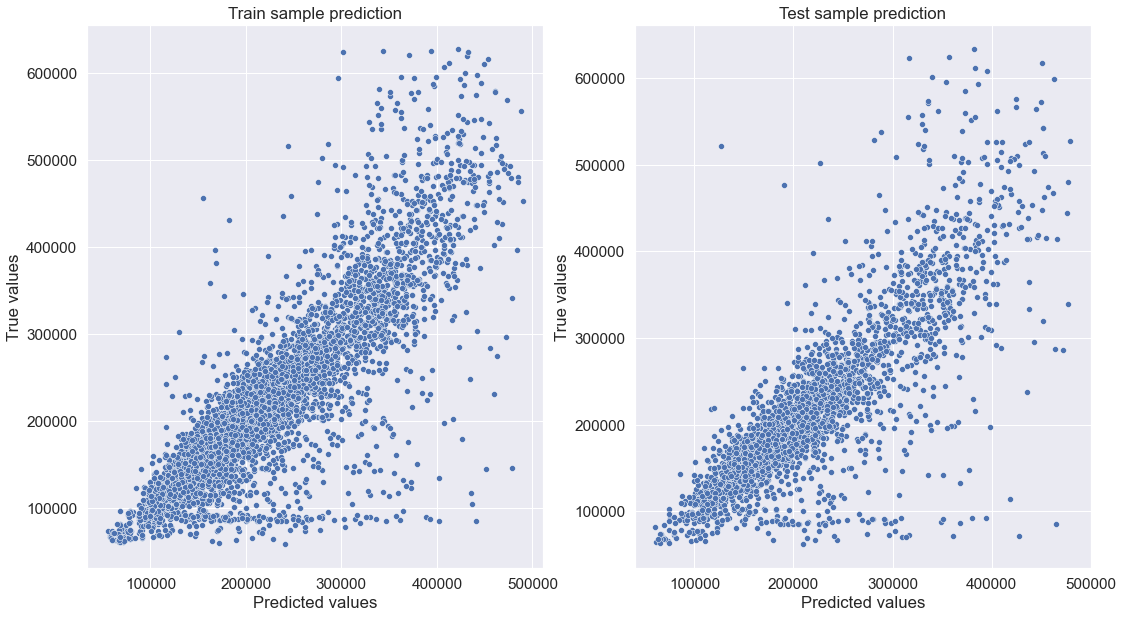

In [47]:
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_valid)
print(model)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

## 4.5. Кросс-валидация <a class='anchor' id='cross_validation'>

### 4.5.1 Основная модель <a class='anchor' id='main_CV'>

In [48]:
# GradientBoostingRegressor
# params = {'loss':['huber'], 
#           'learning_rate':[0.4, 0.5, 0.55, 0.65], 
#           'n_estimators':[400, 525, 650, 775],  
#           'min_samples_leaf':[10, 50, 100],
#           'min_weight_fraction_leaf':[0.1, 0.15, 0.2, 0.25]
#           }

# gs.best_params_
# {'learning_rate': 0.4,
#  'loss': 'huber',
#  'min_samples_leaf': 10,
#  'min_weight_fraction_leaf': 0.1,
#  'n_estimators': 775}
# gs.best_score_ 0.7068913078057734


### 4.5.2 Альтернативные модели <a class='anchor' id='alter_CV'>

In [49]:
# RandomForestRegressor
# params = {'min_samples_split':[2, 20, 50], 
#           'max_depth':[2, 12, 41],
#           'n_estimators': [10, 300, 600],
#           'min_samples_leaf':[2, 20, 53],
#           'min_weight_fraction_leaf':[0.005, 0.25, 0.5]
#           }
# gs.best_params_ 
# {'max_depth': 41,
#  'min_samples_leaf': 2,
#  'min_samples_split': 20,
#  'min_weight_fraction_leaf': 0.005,
#  'n_estimators': 600}
# gs.best_score_ 0.676495778649772


# BaggingRegressor GradientBoostingRegressor
# params = {'n_estimators':[20], 
#           'bootstrap': [False, True],
#           'max_features': [0.3, 0.6, 0.9],
#           'bootstrap_features': [True, False],
#           'max_samples': [0.2, 1.0, 50]}
# gs.best_params_ 
# {'bootstrap': False,
#  'bootstrap_features': False,
#  'max_features': 0.9,
#  'max_samples': 1.0,
#  'n_estimators': 20}
# gs.best_score_ 0.7094533562586718

# BaggingRegressor RandomForestRegressor
# params = {'n_estimators':[20], 
#           'bootstrap': [False, True],
#           'max_features': [0.3, 0.6, 0.9],
#           'bootstrap_features': [True, False],
#           'max_samples': [0.2, 1.0, 50]}
# gs.best_params_ 
# {'bootstrap': False,
#  'bootstrap_features': False,
#  'max_features': 0.9,
#  'max_samples': 1.0,
#  'n_estimators': 20}
# gs.best_score_ 0.6796644128210101


# AdaBoostRegressor GradientBoostingRegressor
# params = {'n_estimators':[10, 50, 100],
#           'learning_rate': [1.0, 0.5, 4],
#           'loss':['linear', 'square', 'exponential']
#          }
# # gs.best_params_ 
# {'learning_rate': 0.5, 
#  'loss': 'exponential', 
#  'n_estimators': 10}
# gs.best_score_ 0.6821894405500379

# AdaBoostRegressor RandomForestRegressor
# params = {'n_estimators':[10, 50, 100],
#           'learning_rate': [1.0, 0.5, 4],
#           'loss':['linear', 'square', 'exponential']
#          }
# # # gs.best_params_ 
# {'learning_rate': 1.0, 
#  'loss': 'exponential', 
#  'n_estimators': 10}
# gs.best_score_ 0.684921976532647


# ExtraTreesRegressor
# params = {'n_estimators':[10, 100, 400],
#           'max_depth': [5, 30, 100],
#           'min_samples_split': [5, 15, 35],
#           'min_samples_leaf': [1, 24, 50],
#           'max_leaf_nodes': [9],
#           'min_weight_fraction_leaf': [0.0, 0.25, 0.5],
#            'max_features': ['auto', 'sqrt', 'log2'],
#           'bootstrap':[True]
#          }
# # gs.best_params_ 
# {'bootstrap': True,
#  'max_depth': 5,
#  'max_features': 'auto',
#  'max_leaf_nodes': 9,
#  'min_samples_leaf': 1,
#  'min_samples_split': 15,
#  'min_weight_fraction_leaf': 0.0,
#  'n_estimators': 400}
# gs.best_score_ 0.5417245550924904

In [50]:
# %%time
# gs = GridSearchCV(model, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=3,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs.fit(X_train, y_train)

In [51]:
# gs.best_score_

In [52]:
# gs.best_params_

In [ ]:
cv_score = cross_val_score(model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=23))
cv_score

In [ ]:
cv_score.mean()

## 4.6. Важность признаков <a class='anchor' id='feature_importance'>

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

## 4.7. Прогнозирование на тестовом датасете <a class='anchor' id='forecasting'>

In [ ]:
test_df.shape

In [ ]:
test_df

In [ ]:
submit = pd.read_csv(SAMPLE_SUBMISSION_PATH)
submit.head()

In [ ]:
predictions = model.predict(test_df)
predictions

In [ ]:
submit['Price'] = predictions
submit.head()

In [ ]:
submit.to_csv('./result/rf_submit.csv', index=False)